<a href="https://colab.research.google.com/github/dnguyend/MiscCollection/blob/main/colab/EinsteinRicciSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ricci Tensor and Einstein metrics on $SO(p)$ with left-invariant diagonal metrics.
We show how to use a simple formula for the Ricci tensor, when the metric on $SO(p)$ is given by $\langle A, A\rangle_P = \sum_{i<j}a_{ij}^2t_{ij}$ for a matrix $A=(a_{ij})_{1\leq i\leq p, 1\leq j\leq p}$ then the Ricci tensor is given by $Ric(A, A) = \sum_{i<j}a_{ij}^2r_{ij}$ with
$$r_{ij} = p-2+ \frac{1}{2}\sum_{l\neq i, l\neq j}\frac{t_{ij}^2-t_{il}^2-t_{jl}^2}{t_{il}t_{jl}}
$$
to solve for Einstein metrics on $SO(p)$

We can run the codes cell by cell but we can just follow the code without the run. Some cell does not return values as it may contain definition only.

First - we implement the formula. We keep the metric as either a vector $t$ of size $p(p-1)/2$, or a $p\times p$ symmetric matrix with diagonal zero

In [1]:
import numpy as np
import contextlib
from scipy.optimize import minimize


def RicciCoeff(Tmat):
    # Tmat is the metric matrix
    p = Tmat.shape[0]
    nup = p*(p-1)//2
    ret = np.zeros(nup)
    ret[:] = p-2
    tx = np.triu_indices(p, 1)
    for kk in range(nup):
        i, j = tx[0][kk], tx[1][kk]
        for aa in range(p):
            if i != aa and aa != j:
                ret[kk] += -0.5*Tmat[j, aa]/Tmat[i, aa] - 0.5*Tmat[i, aa]/Tmat[j, aa]
                ret[kk] += 0.5*Tmat[i, j]*Tmat[i, j] / Tmat[i, aa]/Tmat[aa, j]

    return ret


def makeTmat(Tdiag):
  # translating from the vector Tdiag of size p(p-1)/2 to matrix for easier access
    p = .5 * (1 + np.sqrt(1 + 8 * len(Tdiag)))
    p = int(np.round(p))

    Tmat = np.zeros((p, p))
    tx = np.triu_indices(p, 1)
    Tmat[tx] = Tdiag
    Tmat[tx[1], tx[0]] = Tdiag
    return Tmat

  


Now we implement the cost function,  $F = \sum_{i<j}(\lambda_{ij} -\frac{\sum_{ij}\lambda_{ij}}{\frac{1}{2}p(p-1)})^2$ where $\lambda_{ij} = r_{ij}/t_{ij}$. We work with the variable $v_{ij} = 1/t_{ij}$, slightly easier to implement. We set the first coefficient of $v$ to $1$ so the variable is actually a vector of size $p(p-1)/2-1$, called $z$. fgrad returns both the value and the gradient of the cost function in the variable $z$

In [2]:
def x2u(x):
    u = np.ones(x.shape[0]+1)
    u[1:] = x
    return u


def fill_up(val, d):
    ret = np.zeros((d, d))
    ret[np.triu_indices(d, 1)] = val
    return ret


def fgrad(z):
    """ it is slightly more efficient to optimize in v=1/t
    v = [1, z]
      function is sum_{s} (1/nup v.R - v_{s} R_s)^2
      v_s break to pairs v_{ij}, i < j, with v(0, 1) =1
    """  
    def idxv(ll, i):
        """ need ll != i
        """
        if ll < i:
            return ll*(2*p-ll-1)//2 + i-ll-1
        elif ll > i:
            return i*(2*p-i-1)//2 + ll-i-1

    p = .5 * (1 + np.sqrt(1 + 8 * (1+len(z))))
    p = int(np.round(p))
    nup = p*(p-1)//2
    v = np.ones(nup)
    v[1:] = z
    vric = np.full(nup, fill_value=p-2.)*v

    jric = np.zeros((nup, nup-1))
    jric[1:, :] = np.diag(np.ones(nup-1)*(p-2.))
    
    grad = np.zeros(nup)

    tx = np.triu_indices(p, 1)

    for kk in range(nup):
        i, j = tx[0][kk], tx[1][kk]
        for aa in range(p):
            if i != aa and aa != j:
                i_ij = idxv(i, j)                
                i_ja = idxv(j, aa)
                i_ia = idxv(i, aa)
                
                vij = v[i_ij]                
                vja = v[i_ja]
                via = v[i_ia]

                vric[kk] += -0.5*vij*vja/via - 0.5*vij*via/vja
                vric[kk] += 0.5*via*vja/vij
                
                if i_ia > 0:
                    jric[kk, i_ia-1] += 0.5*vij*vja/via/via - 0.5*vij/vja
                    jric[kk, i_ia-1] += 0.5*vja/vij
                    
                if i_ja > 0:
                    jric[kk, i_ja-1] += 0.5*vij*via/vja/vja - 0.5*vij/via
                    jric[kk, i_ja-1] += 0.5*via/vij                    
                if i_ij > 0:
                    jric[kk, i_ij-1] += -0.5*vja/via - 0.5*via/vja
                    jric[kk, i_ij-1] += -0.5*via*vja/vij/vij
                
    c1 = 1/nup*np.sum(vric)
    d1 = 1/nup*np.sum(jric, axis=0)
    f = np.sum((c1 - vric)*(c1 - vric))
    grad = 2*(c1 - vric)@(d1[None, :] - jric)
    return f, grad


A quick check of the gradient:


In [3]:
p = 9
nup = p*(p-1)//2
dlt = 1e-6
xi = np.random.randn(nup-1)
x0 = np.random.randn(nup-1)
x0 = 1 + x0 - x0.min()

ff, gg = fgrad(x0)
ff1, gg1 = fgrad(x0+dlt*xi)

print('check gradient %.5f %.5f' % 
      ((fgrad(x0+dlt*xi)[0] - ff)/dlt, np.sum(gg*xi)))


check gradient 2615.00702 2615.00070


Now we run the optimization. We demonstrate that the code recover some known Einstein metrics from the literature. There may be a lot of repeated results, something we hope to avoid in the future. We try to avoid repetition by dividing the metric by it smallest coefficient then compare to see if a new run produce a new metric. We start with 100 runs

In [4]:
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally:
        np.set_printoptions(**original)


def pprint(mat, precision=4):
    """pretty print numpy matrix
    """
    with printoptions(precision=precision, suppress=True):
        print(mat)

def test_fg(N=100):
    p = 9
    nup = p*(p-1)//2
    
    def x2u(x):
        u = np.ones(nup)
        u[1:] = x
        return u
    
    rets = {}    
    bounds = (nup-1)*[(1e-6, np.inf)]


    np.random.seed(0)
    for i in range(N):
        x0 = np.random.randn(nup-1)
        x0 = 1 + x0 - x0.min()
        ret = minimize(fgrad, x0=x0, jac=True, tol=1e-8, bounds=bounds)
        tops = x2u(1/ret['x'])
        tops = tops / tops.min()
        rets[i] = {
            'cost': fgrad(ret['x'])[0],
            'wght': tops,
            'rtio': RicciCoeff(makeTmat(tops)) / tops
            }

    sst = np.zeros((N, 5))
    cnt = 0
    for i in range(N):
        if (rets[i]['cost'] < 1e-3) and (rets[i]['rtio'].min() > 0):
            sst[cnt, :] = [i, rets[i]['cost'],
                           rets[i]['rtio'].min(),
                           rets[i]['rtio'].max(),
                           rets[i]['rtio'].max() - rets[i]['rtio'].min()]
            cnt += 1
    sst = sst[:cnt, :]
    sst = sst[np.argsort(sst[:, 2])]
    last = - 1
    good = []
    for i in range(sst.shape[0]):
        if np.abs(sst[i, 3] - last) > 1e-2:
            ix = int(sst[i, 0])
            # print(ix, rets[ix])
            last = sst[i, 3]
            good.append(ix)
    print(good)

    # with open('tryit%d.npz' % n, 'wb') as ff:
    #    np.savez_compressed(ff, sst=sst, rets=rets)

    def summarize(ixx):
        ss = np.sort(rets[good[ixx]]['wght']/rets[good[ixx]]['wght'].min())
        diff = np.abs(ss[1:]/ss[:-1]-1)
        print('Doing %d' % ixx)
        # print(ss)
        pprint(makeTmat(rets[good[ixx]]['wght']/rets[good[ixx]]['wght'].min()), 4)
        print('cost=%f' % rets[good[ixx]]['cost'])
        mark = np.where(diff > 1e-2)[0]
        last = 0
        tot_cnt = 0
        for i in range(mark.shape[0]):
            if mark[i] == last:
                val = np.mean(ss[last:last+1])
                cnt = 1
                print(val, cnt)
                last = last + 1
                tot_cnt += 1
            else:
                val = np.mean(ss[last:mark[i]])
                cnt = mark[i] - last+1
                print(val, cnt)
                last = mark[i]+1
                tot_cnt += 1
        val = np.mean(ss[last:])
        if ss[last:].shape[0] > 0:
            print(val, ss[last:].shape[0])
            tot_cnt += 1
        print('tot_cnt = %d' % tot_cnt)

    for ixx in range(len(good)):
        summarize(ixx)

np.random.seed(0)
test_fg(N=100)

[90, 35, 55]
Doing 0
[[0.     2.6973 2.0495 2.6973 2.6973 2.0495 2.0495 2.0495 2.0495]
 [2.6973 0.     2.0494 2.6972 2.6972 2.0494 2.0495 2.0495 2.0494]
 [2.0495 2.0494 0.     2.0495 2.0494 1.     1.     1.     1.    ]
 [2.6973 2.6972 2.0495 0.     2.6972 2.0495 2.0495 2.0495 2.0495]
 [2.6973 2.6972 2.0494 2.6972 0.     2.0494 2.0494 2.0494 2.0494]
 [2.0495 2.0494 1.     2.0495 2.0494 0.     1.     1.     1.    ]
 [2.0495 2.0495 1.     2.0495 2.0494 1.     0.     1.     1.    ]
 [2.0495 2.0495 1.     2.0495 2.0494 1.     1.     0.     1.    ]
 [2.0495 2.0494 1.     2.0495 2.0494 1.     1.     1.     0.    ]]
cost=0.000000
1.0000095299465077 10
2.0494659071048016 20
2.697257858810046 6
tot_cnt = 3
Doing 1
[[0.     2.1066 1.6536 2.1065 1.6536 1.6536 1.6536 1.6536 1.6536]
 [2.1066 0.     1.6536 2.1064 1.6536 1.6536 1.6536 1.6536 1.6536]
 [1.6536 1.6536 0.     1.6535 1.     1.     1.     1.     1.    ]
 [2.1065 2.1064 1.6535 0.     1.6535 1.6535 1.6535 1.6535 1.6535]
 [1.6536 1.6536 1.    

There are 3 metrics found - they are all known from D'Atri-Ziller. A more extensive run produce more old metrics, sometime new metrics, in particular the two below for $SO(9)$

In [5]:
def verify_so9():
    flgs = np.array([1, 1, 3, 4])
    Tdiag = [11.7750044, 3.49295668, 3.49295668,  3.49295668,
             11.00395784, 11.00395784, 11.00395784, 11.00395784,
             11.42167356, 11.42167356, 11.42167356,  4.85823252, 4.85823252,
             4.85823252,  4.85823252, 1., 1., 10.63219969, 10.63219969,
             10.63219969, 10.63219969, 1., 10.63219969, 10.63219969,
             10.63219969, 10.63219969,
             10.63219969, 10.63219969, 10.63219969, 10.63219969,
             2.07232593,  2.07232593, 2.07232593,
             2.07232593,  2.07232593, 2.07232593]
    
    p = flgs.sum()
    Tmat = makeTmat(Tdiag)
    rcf = RicciCoeff(Tmat)
    print('flag = %s' % flgs)
    print("coefficients")
    pprint(Tmat)
    lbd = rcf/Tdiag
    print("Ratios")
    pprint(makeTmat(lbd))
    
    print('Ratio =%.5f standard deviation = %f' % (lbd.min(), np.std(lbd)))
    
    flgs = np.array([1, 2, 3, 3])

    Tdiag = [11.41086965, 11.41086965, 10.83434028, 10.83434028, 10.83434028,
             3.50463883,  3.50463883,  3.50463883, 
             5.68181449,  4.25394966,  4.25394966,  4.25394966, 11.04723483,
             11.04723483, 11.04723483, 4.25394966,  4.25394966, 4.25394966,
             11.04723483, 11.04723483, 11.04723483, 1.02563286, 1.02563286,
             10.45556196, 10.45556196, 10.45556196, 1.02563286, 10.45556196,
             10.45556196, 10.45556196, 10.45556196, 10.45556196, 10.45556196,
             1., 1., 1.]
    p = flgs.sum()
    Tmat = makeTmat(Tdiag)
    rcf = RicciCoeff(Tmat)
    print('flag = %s' % flgs)    
    print("coefficients")
    pprint(Tmat)
    lbd = rcf/Tdiag
    print("Ratios")
    pprint(makeTmat(lbd))
    
    print('Ratio =%.5f standard deviation = %f' % (lbd.min(), np.std(lbd)))
    
verify_so9()

flag = [1 1 3 4]
coefficients
[[ 0.     11.775   3.493   3.493   3.493  11.004  11.004  11.004  11.004 ]
 [11.775   0.     11.4217 11.4217 11.4217  4.8582  4.8582  4.8582  4.8582]
 [ 3.493  11.4217  0.      1.      1.     10.6322 10.6322 10.6322 10.6322]
 [ 3.493  11.4217  1.      0.      1.     10.6322 10.6322 10.6322 10.6322]
 [ 3.493  11.4217  1.      1.      0.     10.6322 10.6322 10.6322 10.6322]
 [11.004   4.8582 10.6322 10.6322 10.6322  0.      2.0723  2.0723  2.0723]
 [11.004   4.8582 10.6322 10.6322 10.6322  2.0723  0.      2.0723  2.0723]
 [11.004   4.8582 10.6322 10.6322 10.6322  2.0723  2.0723  0.      2.0723]
 [11.004   4.8582 10.6322 10.6322 10.6322  2.0723  2.0723  2.0723  0.    ]]
Ratios
[[0.     0.5625 0.5625 0.5625 0.5625 0.5625 0.5625 0.5625 0.5625]
 [0.5625 0.     0.5625 0.5625 0.5625 0.5625 0.5625 0.5625 0.5625]
 [0.5625 0.5625 0.     0.5625 0.5625 0.5625 0.5625 0.5625 0.5625]
 [0.5625 0.5625 0.5625 0.     0.5625 0.5625 0.5625 0.5625 0.5625]
 [0.5625 0.5625 0.5625 

To reduce the number of variables (instead of $p(p-1)/2$) we divide the $p\times p$ to blocks with coefficients in the same blocks only. This is a simple application of the chain rule. We run over all partitions for $p=9$. Again there are a lot of repetition but we hope this demonstrates the method is sufficiently robust. The two examples above are in the run below, but appearing in a subpartition.

## The very large values on some output is because the minimizer find solutions at the boundary of the search domain. With appropriate normalization, these corresponds to degenerate metrics where some coefficients $t_{ij} = 0$, so they should be ignored.

## Solution from a subpartition may include solutions of its parent partitions.

In [6]:
def partitions(n, II=1):
  # list all partition of N
    yield (n,)
    for i in range(II, n//2 + 1):
        for p in partitions(n-i, i):
            yield (i,) + p  

def makeFF_idx(flgs):
    # Label a square matrix, deciding which variable goes to which block
    q = flgs.shape[0]
    n = flgs.sum()
    mat = np.zeros((n, n), dtype=int)
    mat[:flgs[0], :flgs[0]] = fill_up(1, flgs[0])
    rstart = 0
    cstart = 0
    wdim = 1
    for i in range(q):
        cstart = rstart
        for j in range(i, q):
            if i == j:        
                mat[rstart:rstart + flgs[i], cstart:cstart + flgs[i]] =\
                    fill_up(wdim, flgs[i])
                if flgs[i] > 1:
                    wdim += 1
            else:
                mat[rstart:rstart + flgs[i], cstart:cstart + flgs[j]] = wdim
                wdim += 1
            cstart += flgs[j]
        
        rstart += flgs[i]
    return mat[np.triu_indices(n, 1)][1:]-2, wdim-2

def do_one_flag(flgs, N=10):
    print('Doing flag = %s' % str(flgs))
    n = flgs.sum()
    nup = n*(n-1)//2

    vec_idx, wdim = makeFF_idx(flgs)

    def w2zFF(w):
        z = np.ones(nup-1)
        for i in range(w.shape[0]):
            z[np.where(vec_idx == i)] = w[i]
        return z

    def fgrwFF(w):
        ff, gg = fgrad(w2zFF(w))
        return ff, np.array(
            [gg[np.where(vec_idx == i)].sum() for i in range(w.shape[0])])

    bounds = wdim*[(1e-6, np.inf)]

    rets = {}
    for i in range(N):
        w0 = np.random.randint(1, 100, wdim)*.1
        # w0 = 1 + w0 - w0.min()
        ret = minimize(fgrwFF, x0=w0, jac=True, tol=1e-10, bounds=bounds)
        tops = x2u(w2zFF(1/ret['x']))
        tops = tops / tops.min()
        rets[i] = {
            'cost': fgrwFF(ret['x'])[0],
            'w': ret['x'],
            'wght': tops,
            'rtio': RicciCoeff(makeTmat(tops)) / tops
        }
    sst = np.zeros((N, 5))
    cnt = 0
    for i in range(N):
        if (rets[i]['cost'] < 1e-3) and (rets[i]['rtio'].min() > 0):
            sst[cnt, :] = [i, rets[i]['cost'],
                           rets[i]['rtio'].min(),
                           rets[i]['rtio'].max(),
                           rets[i]['rtio'].max() - rets[i]['rtio'].min()]
            cnt += 1
    sst = sst[:cnt, :]
    sst = sst[np.argsort(sst[:, 2])]
    last = - 1
    good = []
    for i in range(sst.shape[0]):
        if np.abs(sst[i, 3] - last) > 1e-2:
            ix = int(sst[i, 0])
            # print(ix, rets[ix])
            last = sst[i, 3]
            good.append(ix)
    print(good)

    with open('new_son%s.npz' % '_'.join(
            [str(n)] + [str(i) for i in flgs]), 'wb') as ff:
        np.savez_compressed(ff, sst=sst, rets=rets)
        
    def summarize(ixx):
        Tvec = rets[good[ixx]]['wght'] / rets[good[ixx]]['wght'].min()
        ss = np.sort(Tvec)
        diff = np.abs(ss[1:]/ss[:-1]-1)
        print('Summarize Doing %d' % ixx)
        pprint(makeTmat(Tvec))
        print('sorted', ss, rets[good[ixx]]['rtio'].mean(),
              rets[good[ixx]]['rtio'].std())
        mark = np.where(diff > 1e-3)[0]
        last = 0
        tot_cnt = 0        
        for i in range(mark.shape[0]):
            if mark[i] == last:
                val = np.mean(ss[last:last + 1])
                cnt = 1
                print(val, cnt)
                last = last + 1
                tot_cnt += 1
            else:
                val = np.mean(ss[last:mark[i]])
                cnt = mark[i] - last+1
                print(val, cnt)
                last = mark[i]+1
                tot_cnt += 1                
        val = np.mean(ss[last:])
        print(val, ss[last:].shape[0])
        print('tot_cnt: %d' % (tot_cnt+1))

    for ixx in range(len(good)):
        summarize(ixx)
    return rets, sst

def test_all_flags():
    n = 9
    np.random.seed(0)
    all_flags = sorted([np.array(a) for a in partitions(n)],
                       key=lambda x: x.shape[0])[1:-1]
    for flgs in all_flags:
        _ = do_one_flag(flgs, N=30)

test_all_flags()

Doing flag = [1 8]
[16, 26]
Summarize Doing 0
[[0.     1.3333 1.3333 1.3333 1.3333 1.3333 1.3333 1.3333 1.3333]
 [1.3333 0.     1.     1.     1.     1.     1.     1.     1.    ]
 [1.3333 1.     0.     1.     1.     1.     1.     1.     1.    ]
 [1.3333 1.     1.     0.     1.     1.     1.     1.     1.    ]
 [1.3333 1.     1.     1.     0.     1.     1.     1.     1.    ]
 [1.3333 1.     1.     1.     1.     0.     1.     1.     1.    ]
 [1.3333 1.     1.     1.     1.     1.     0.     1.     1.    ]
 [1.3333 1.     1.     1.     1.     1.     1.     0.     1.    ]
 [1.3333 1.     1.     1.     1.     1.     1.     1.     0.    ]]
sorted [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.33333334 1.33333334
 1.33333334 1.33333334 1.33333334 1.33333334 1.33

## The following is an example of $SO(20)$
with a flag of length 5. It it could be arranged to flag of length 7 $(1, 2, 2, 2, 3, 5, 5)$. So it is tricky to figure out isometric metrics. The next two examples are just permutation and scaling of each other. An extensive search with the code provided above returns numerous metrics for $SO(20)$ with different flag size, and it is a challenge to distinguish them.

In [7]:
from google.colab import data_table
import pandas as pd

def so20():
  flgs = np.array([2, 3, 5, 5, 5])
  vals = np.array([1.        , 2.71654802, 2.61003108, 3.3950997 , 0.76562301,
           1.24752592, 0.94988487, 2.3171043 , 2.64821358, 0.37093517,
           2.19030637, 2.53940464, 0.31935525, 3.33608328, 0.3629275 ])

  p = flgs.sum()
  vec_idx, _ = makeFF_idx(flgs)
  # vec_idx has the first cell cut out. we append it in
  place = np.concatenate([np.zeros(1), vec_idx+1])
  Tdiag = np.ones(p*(p-1)//2)
  for i in range(vals.shape[0]):
    Tdiag[np.where(place == i)] = vals[i]

  # normalize setting smallest value to 1
  Tdiag = Tdiag/Tdiag.min()
  lbd = RicciCoeff(makeTmat(Tdiag))/Tdiag
  print("ratio mean=%f std=%", (lbd.mean(), np.std(lbd)))
  print("metric vector", Tdiag)
  print("metric matrix")
  
  
  return data_table.DataTable(pd.DataFrame(makeTmat(Tdiag)), num_rows_per_page=p)
so20()

ratio mean=%f std=% (1.6133980094931806, 3.152115174299956e-07)
metric vector [ 3.1313091   8.50635153  8.50635153  8.50635153  8.17281407  8.17281407
  8.17281407  8.17281407  8.17281407 10.63110658 10.63110658 10.63110658
 10.63110658 10.63110658  2.3974023   2.3974023   2.3974023   2.3974023
  2.3974023   8.50635153  8.50635153  8.50635153  8.17281407  8.17281407
  8.17281407  8.17281407  8.17281407 10.63110658 10.63110658 10.63110658
 10.63110658 10.63110658  2.3974023   2.3974023   2.3974023   2.3974023
  2.3974023   3.90638926  3.90638926  2.97438314  2.97438314  2.97438314
  2.97438314  2.97438314  7.25556978  7.25556978  7.25556978  7.25556978
  7.25556978  8.29237528  8.29237528  8.29237528  8.29237528  8.29237528
  3.90638926  2.97438314  2.97438314  2.97438314  2.97438314  2.97438314
  7.25556978  7.25556978  7.25556978  7.25556978  7.25556978  8.29237528
  8.29237528  8.29237528  8.29237528  8.29237528  2.97438314  2.97438314
  2.97438314  2.97438314  2.97438314  7.25556978

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,3.131309,8.506352,8.506352,8.506352,8.172814,8.172814,8.172814,8.172814,8.172814,10.631107,10.631107,10.631107,10.631107,10.631107,2.397402,2.397402,2.397402,2.397402,2.397402
1,3.131309,0.000000,8.506352,8.506352,8.506352,8.172814,8.172814,8.172814,8.172814,8.172814,10.631107,10.631107,10.631107,10.631107,10.631107,2.397402,2.397402,2.397402,2.397402,2.397402
2,8.506352,8.506352,0.000000,3.906389,3.906389,2.974383,2.974383,2.974383,2.974383,2.974383,7.255570,7.255570,7.255570,7.255570,7.255570,8.292375,8.292375,8.292375,8.292375,8.292375
3,8.506352,8.506352,3.906389,0.000000,3.906389,2.974383,2.974383,2.974383,2.974383,2.974383,7.255570,7.255570,7.255570,7.255570,7.255570,8.292375,8.292375,8.292375,8.292375,8.292375
4,8.506352,8.506352,3.906389,3.906389,0.000000,2.974383,2.974383,2.974383,2.974383,2.974383,7.255570,7.255570,7.255570,7.255570,7.255570,8.292375,8.292375,8.292375,8.292375,8.292375
5,8.172814,8.172814,2.974383,2.974383,2.974383,0.000000,1.161513,1.161513,1.161513,1.161513,6.858526,6.858526,6.858526,6.858526,6.858526,7.951661,7.951661,7.951661,7.951661,7.951661
6,8.172814,8.172814,2.974383,2.974383,2.974383,1.161513,0.000000,1.161513,1.161513,1.161513,6.858526,6.858526,6.858526,6.858526,6.858526,7.951661,7.951661,7.951661,7.951661,7.951661
7,8.172814,8.172814,2.974383,2.974383,2.974383,1.161513,1.161513,0.000000,1.161513,1.161513,6.858526,6.858526,6.858526,6.858526,6.858526,7.951661,7.951661,7.951661,7.951661,7.951661
8,8.172814,8.172814,2.974383,2.974383,2.974383,1.161513,1.161513,1.161513,0.000000,1.161513,6.858526,6.858526,6.858526,6.858526,6.858526,7.951661,7.951661,7.951661,7.951661,7.951661
9,8.172814,8.172814,2.974383,2.974383,2.974383,1.161513,1.161513,1.161513,1.161513,0.000000,6.858526,6.858526,6.858526,6.858526,6.858526,7.951661,7.951661,7.951661,7.951661,7.951661


In [8]:
def so20_7():
  vals = np.array([1.        , 0.45923227, 0.34966583, 0.34966586, 0.85295839,
  0.97484503, 0.36811405, 0.99999925, 0.96078907, 0.96078916,
  1.24978391, 0.28183659, 0.45923092, 0.34966607, 0.349666  ,
  0.85295879, 0.97484444, 0.13654663, 0.13654643, 0.80628269,
  0.93479058, 0.13654644, 0.80628247, 0.93479051, 0.11755916,
  1.22805914, 0.13359871])
  flgs = np.array([1, 2, 2, 2, 3, 5, 5])
  # this is actually a [2, 3, 5, 5, 5] flag

  p = flgs.sum()
  vec_idx, _ = makeFF_idx(flgs)
  # vec_idx has the first cell cut out. we append it in
  place = np.concatenate([np.zeros(1), vec_idx+1])
  Tdiag = np.empty(p*(p-1)//2)
  for i in range(vals.shape[0]):
    Tdiag[np.where(place == i)] = vals[i]
  Tdiag = Tdiag/Tdiag.min()
  lbd = RicciCoeff(makeTmat(Tdiag))/Tdiag
  print("ratio mean=%f std=%", (lbd.mean(), np.std(lbd)))
  print("metric vector", Tdiag)
  print("metric matrix")
  
  
  return data_table.DataTable(pd.DataFrame(makeTmat(Tdiag)), num_rows_per_page=p)
  # pprint(, 5)  

so20_7()




ratio mean=%f std=% (1.6133980658981697, 5.972227466561805e-07)
metric vector [ 8.50635544  8.50635544  3.90639292  3.90639292  2.97438183  2.97438183
  2.97438209  2.97438209  2.97438209  7.25556724  7.25556724  7.25556724
  7.25556724  7.25556724  8.29237832  8.29237832  8.29237832  8.29237832
  8.29237832  3.13130895  8.50634906  8.50634906  8.17281333  8.17281333
  8.1728141   8.1728141   8.1728141  10.63110616 10.63110616 10.63110616
 10.63110616 10.63110616  2.39740221  2.39740221  2.39740221  2.39740221
  2.39740221  8.50634906  8.50634906  8.17281333  8.17281333  8.1728141
  8.1728141   8.1728141  10.63110616 10.63110616 10.63110616 10.63110616
 10.63110616  2.39740221  2.39740221  2.39740221  2.39740221  2.39740221
  3.90638143  2.97438388  2.97438388  2.97438328  2.97438328  2.97438328
  7.25557064  7.25557064  7.25557064  7.25557064  7.25557064  8.2923733
  8.2923733   8.2923733   8.2923733   8.2923733   2.97438388  2.97438388
  2.97438328  2.97438328  2.97438328  7.25557064

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,8.506355,8.506355,3.906393,3.906393,2.974382,2.974382,2.974382,2.974382,2.974382,7.255567,7.255567,7.255567,7.255567,7.255567,8.292378,8.292378,8.292378,8.292378,8.292378
1,8.506355,0.000000,3.131309,8.506349,8.506349,8.172813,8.172813,8.172814,8.172814,8.172814,10.631106,10.631106,10.631106,10.631106,10.631106,2.397402,2.397402,2.397402,2.397402,2.397402
2,8.506355,3.131309,0.000000,8.506349,8.506349,8.172813,8.172813,8.172814,8.172814,8.172814,10.631106,10.631106,10.631106,10.631106,10.631106,2.397402,2.397402,2.397402,2.397402,2.397402
3,3.906393,8.506349,8.506349,0.000000,3.906381,2.974384,2.974384,2.974383,2.974383,2.974383,7.255571,7.255571,7.255571,7.255571,7.255571,8.292373,8.292373,8.292373,8.292373,8.292373
4,3.906393,8.506349,8.506349,3.906381,0.000000,2.974384,2.974384,2.974383,2.974383,2.974383,7.255571,7.255571,7.255571,7.255571,7.255571,8.292373,8.292373,8.292373,8.292373,8.292373
5,2.974382,8.172813,8.172813,2.974384,2.974384,0.000000,1.161514,1.161512,1.161512,1.161512,6.858527,6.858527,6.858527,6.858527,6.858527,7.951661,7.951661,7.951661,7.951661,7.951661
6,2.974382,8.172813,8.172813,2.974384,2.974384,1.161514,0.000000,1.161512,1.161512,1.161512,6.858527,6.858527,6.858527,6.858527,6.858527,7.951661,7.951661,7.951661,7.951661,7.951661
7,2.974382,8.172814,8.172814,2.974383,2.974383,1.161512,1.161512,0.000000,1.161513,1.161513,6.858525,6.858525,6.858525,6.858525,6.858525,7.951660,7.951660,7.951660,7.951660,7.951660
8,2.974382,8.172814,8.172814,2.974383,2.974383,1.161512,1.161512,1.161513,0.000000,1.161513,6.858525,6.858525,6.858525,6.858525,6.858525,7.951660,7.951660,7.951660,7.951660,7.951660
9,2.974382,8.172814,8.172814,2.974383,2.974383,1.161512,1.161512,1.161513,1.161513,0.000000,6.858525,6.858525,6.858525,6.858525,6.858525,7.951660,7.951660,7.951660,7.951660,7.951660


## We ran a large simulation and get around $1500$ potential Einstein metrics 

"Potential" as their Ricci multiplier is almost constant (deviation in order of $10^{-6}, 10^{-5}$), but some work is needed to show how far they are from an actual solution from the Einstein equation and verify of how many duplications we may have.

By comparing the multipliers with the metrics normalized so that the smallest coefficient is $1$, we will see even if there is only a fraction of the metrics are not equivalent, there are still a lot of metrics.  We will load the file then summarize the data

In [64]:
!wget https://raw.githubusercontent.com/dnguyend/MiscCollection/main/colab/ricci_coeff_so20.csv

--2021-10-07 02:27:47--  https://raw.githubusercontent.com/dnguyend/MiscCollection/main/colab/ricci_coeff_so20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5726670 (5.5M) [text/plain]
Saving to: ‘ricci_coeff_so20.csv’

ricci_coeff_so20.cs 100%[===================>]   5.46M  --.-KB/s    in 0.08s   

2021-10-07 02:27:47 (68.5 MB/s) - ‘ricci_coeff_so20.csv’ saved [5726670/5726670]



In [65]:
import csv
simfile = []
with open ('ricci_coeff_so20.csv') as ff:
  h = csv.reader(ff)
  for l in h:
    simfile.append(l)


# Recompute the Coefficient and the multipliers

In [66]:
lbdmean = np.empty(len(simfile)-1)
lbdstd = np.empty(len(simfile)-1)
for i in range(len(simfile)-1):
  v = np.array([float(a) for a in simfile[i+1][1:191]])
  lbd = RicciCoeff(makeTmat(v))/v
  lbdmean[i] = lbd.mean()
  lbdstd[i] = np.std(lbd)

For each metric Ricci multipliers are practically constant
std of multiplier within a metric, over all metrics max=0.001853 meadian =0.000001 mean=0.000009


Text(0.5, 1.0, 'Distribution of Ricci multipliers')

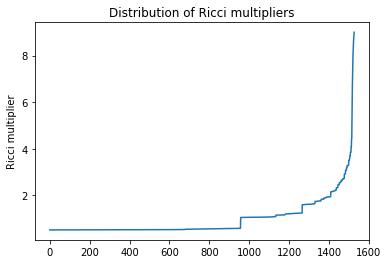

In [67]:
import matplotlib.pyplot as plt
print("For each metric Ricci multipliers are practically constant")
print('std of multiplier within a metric, over all metrics max=%f meadian =%f mean=%f' % (lbdstd.max(), np.median(lbdstd), np.mean(lbdstd)))
fig, ax = plt.subplots()
ax.plot(np.arange(lbdmean.shape[0]), lbdmean)
ax.set_ylabel("output line number")
ax.set_ylabel("Ricci multiplier")
ax.set_title("Distribution of Ricci multipliers")
# plt.plot(lbdmean)
# plt.plot(lbdmean[800:])

Each line in the simfile represents a metric, although there may be some duplication despite our best effort.

Sample line - the coefficients, $190 = 19\times 20/2$ of them, and then the flag that may be closest to the data, and then some strings indicating how we ran the sim (pls ignore) then the Ricci coefficient and its variation (standard deviation), then a summarization of the coefficients (eg, $3$ value of $t_{ij} = 1$, $105$ values of $t_{ij} = 15.014$ etc. in this case. The last entry is the total number of distinct coefficient for this line. 

In [68]:
print(simfile[0])
print(simfile[2])

['row', 'tval1', 'tval2', 'tval3', 'tval4', 'tval5', 'tval6', 'tval7', 'tval8', 'tval9', 'tval10', 'tval11', 'tval12', 'tval13', 'tval14', 'tval15', 'tval16', 'tval17', 'tval18', 'tval19', 'tval20', 'tval21', 'tval22', 'tval23', 'tval24', 'tval25', 'tval26', 'tval27', 'tval28', 'tval29', 'tval30', 'tval31', 'tval32', 'tval33', 'tval34', 'tval35', 'tval36', 'tval37', 'tval38', 'tval39', 'tval40', 'tval41', 'tval42', 'tval43', 'tval44', 'tval45', 'tval46', 'tval47', 'tval48', 'tval49', 'tval50', 'tval51', 'tval52', 'tval53', 'tval54', 'tval55', 'tval56', 'tval57', 'tval58', 'tval59', 'tval60', 'tval61', 'tval62', 'tval63', 'tval64', 'tval65', 'tval66', 'tval67', 'tval68', 'tval69', 'tval70', 'tval71', 'tval72', 'tval73', 'tval74', 'tval75', 'tval76', 'tval77', 'tval78', 'tval79', 'tval80', 'tval81', 'tval82', 'tval83', 'tval84', 'tval85', 'tval86', 'tval87', 'tval88', 'tval89', 'tval90', 'tval91', 'tval92', 'tval93', 'tval94', 'tval95', 'tval96', 'tval97', 'tval98', 'tval99', 'tval100', 

It is easier to show the data in a data table, but best is to take the file and read in a spreadsheet like Excel or Google sheet

In [69]:
df = pd.read_csv('ricci_coeff_so20.csv', usecols=np.arange(195), skiprows=0, header=0, names=simfile[0][:195], index_col=0)
df
# data_table.DataTable(df, num_rows_per_page=10)

,tval1,tval2,tval3,tval4,tval5,tval6,tval7,tval8,tval9,tval10,tval11,tval12,tval13,tval14,tval15,tval16,tval17,tval18,tval19,tval20,tval21,tval22,tval23,tval24,tval25,tval26,tval27,tval28,tval29,tval30,tval31,tval32,tval33,tval34,tval35,tval36,tval37,tval38,tval39,tval40,...,tval155,tval156,tval157,tval158,tval159,tval160,tval161,tval162,tval163,tval164,tval165,tval166,tval167,tval168,tval169,tval170,tval171,tval172,tval173,tval174,tval175,tval176,tval177,tval178,tval179,tval180,tval181,tval182,tval183,tval184,tval185,tval186,tval187,tval188,tval189,tval190,flag,flags_found,einst_coef,std
row,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.000000,1.000000,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,1.000000,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,25.286192,...,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,15.744479,[ 1 2 5 12],"['tryit20_1_2_5_12.npz', 'tryit20_1_2_7_10.npz...",0.513294,2.507300e-08
1,21.195701,27.326327,27.326327,27.326327,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,27.326327,27.326327,27.326327,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,18.376757,1.000000,1.000000,25.034040,...,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,15.014731,[ 1 2 2 15],"['tryit20_1_2_2_15.npz', 'tryit20_1_2_2_2_2_11...",0.513307,6.228059e-08
2,1.000000,1.000000,27.398853,27.398853,27.398853,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,1.000000,27.398853,27.398853,27.398853,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,24.868194,27.398853,27.398853,27.398853,...,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,14.526266,[3 3 3 3 3 5],"['tryit20_3_3_3_3_3_5.npz', 'newrn20_1_2_2_2_3...",0.513316,4.410059e-07
3,1.000000,1.000000,27.470448,27.470448,27.470448,27.470448,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,1.000000,27.470448,27.470448,27.470448,27.470448,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,24.667612,27.470448,27.470448,27.470448,...,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,13.925787,[3 4 6